In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.symbols import ORTH
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from tqdm import tqdm
import gc
import dask
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from collections import defaultdict

In [2]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
# For fancy table Display
# %load_ext google.colab.data_table

dask.config.set(num_workers=8, scheduler='processes')

tqdm.pandas()

In [4]:
# Load the data
metadata_df = pd.read_csv('./data/metadata.csv', low_memory=False)
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

In [5]:
# Explore the metadata
metadata_df.info()
metadata_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544406 entries, 0 to 544405
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          544406 non-null  object 
 1   sha               183834 non-null  object 
 2   source_x          544406 non-null  object 
 3   title             544158 non-null  object 
 4   doi               298986 non-null  object 
 5   pmcid             193683 non-null  object 
 6   pubmed_id         258178 non-null  object 
 7   license           544406 non-null  object 
 8   abstract          396056 non-null  object 
 9   publish_time      544187 non-null  object 
 10  authors           529539 non-null  object 
 11  journal           508745 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  226293 non-null  object 
 14  arxiv_id          7097 non-null    object 
 15  pdf_json_files    183834 non-null  object 
 16  pmc_json_files    14

,mag_id,s2_id
count,0.0,4.952350e+05
mean,NaN,1.976635e+08
std,NaN,6.753983e+07
min,NaN,9.600000e+01
25%,NaN,2.186196e+08
50%,NaN,2.213713e+08
75%,NaN,2.281010e+08
max,NaN,2.333898e+08


In [6]:
# Drop rows with null abstract
metadata_df = metadata_df.loc[~pd.isna(metadata_df['abstract'])]
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

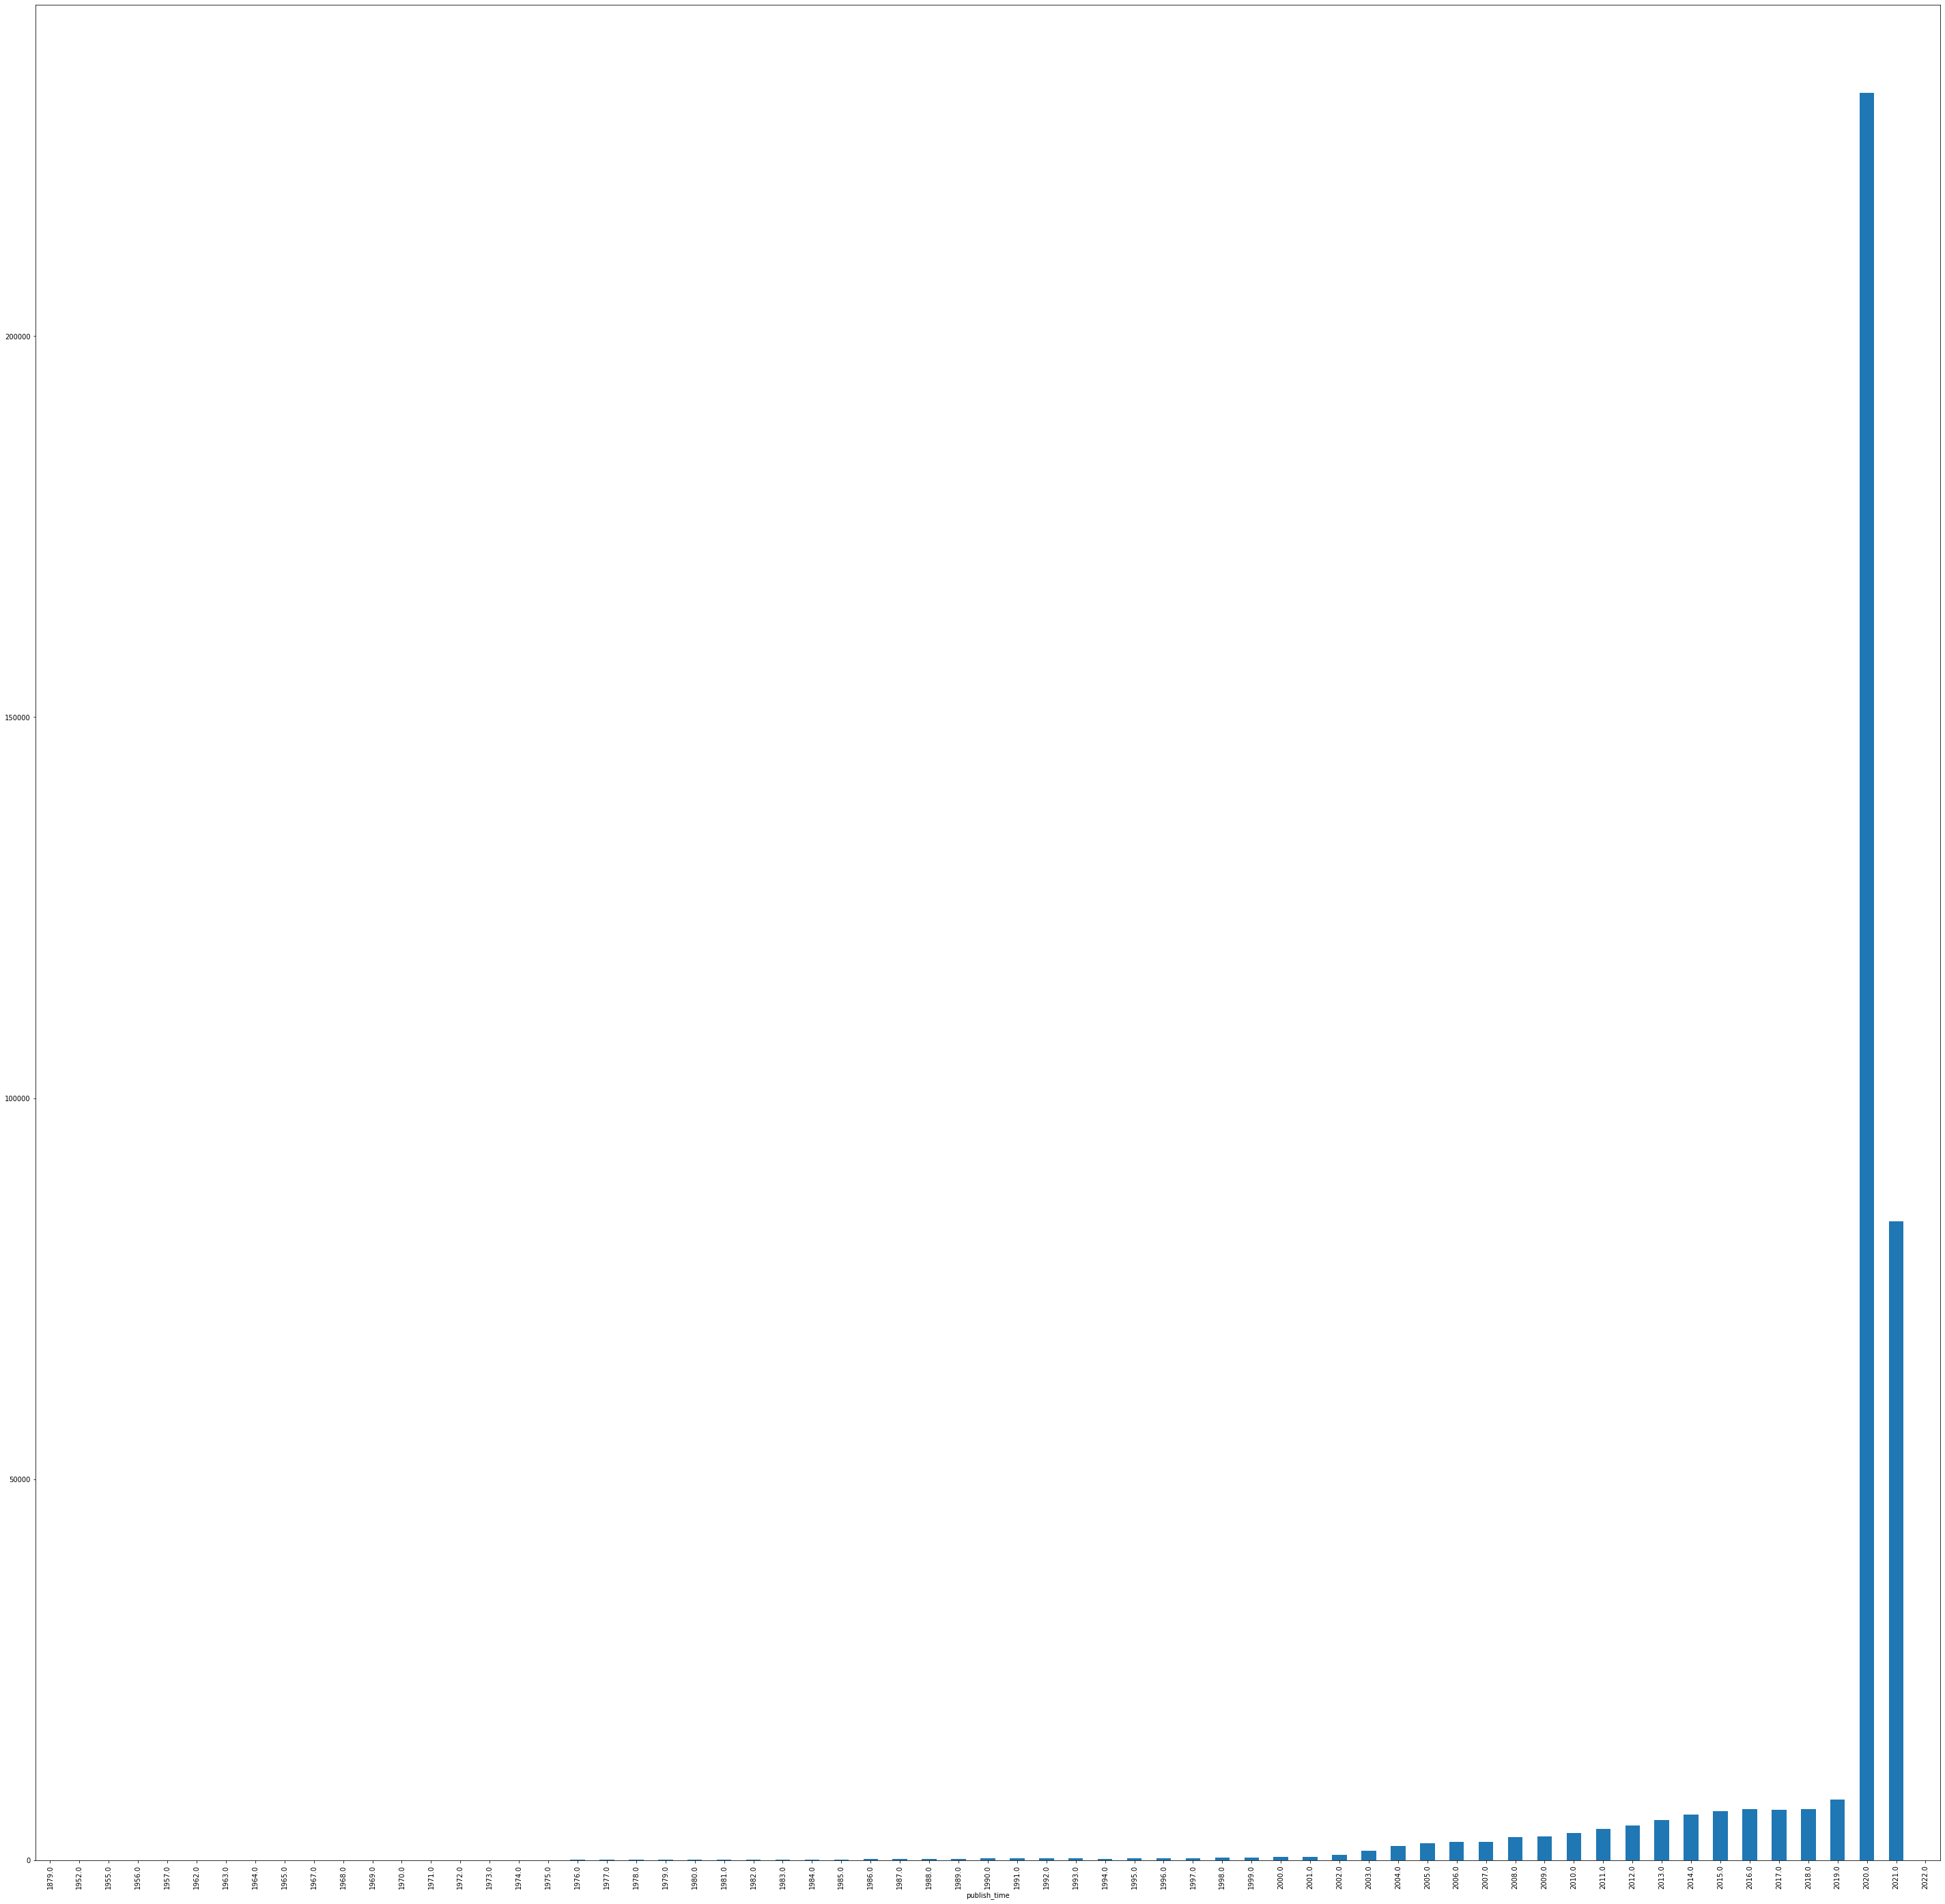

In [29]:
metadata_df['publish_time'] = metadata_df['publish_time'].astype('datetime64')
plt.figure(figsize=(50, 50))
metadata_df['publish_time'].groupby([metadata_df['publish_time'].dt.year]).count().plot(kind='bar')
plt.show()


# metadata_df_aux = metadata_df.copy()

# metadata_df_aux['publish_time'] = metadata_df_aux['publish_time'].replace(to_replace=[pd.NaT], value='1970-01-01')
# metadata_df_aux['publish_time'] = metadata_df_aux['publish_time'].astype(str)
# fig, ax = plt.subplots()
# metadata_df_aux['publish_time'].astype(np.int64).plot.hist(ax=ax)
# labels = ax.get_xticks().tolist()
# labels = pd.to_datetime(labels)
# ax.set_xticklabels(labels, rotation=90)
# plt.show()

In [57]:
from sklearn.utils import shuffle

for idx, row in shuffle(metadata_df).iloc[:10].iterrows():
    print('==============================================================')
    print(row['title'])
    print(row['publish_time'])
    print()
    print(row['abstract'])
    print()
    doc = nlp(row['abstract'])
    print([tk for tk in doc])
    print()
    print([tk.lemma_ for tk in doc])
    print()
    print([tk.pos_ for tk in doc])
    print()
    print('==============================================================')
    print('\n')

Way Forward on COVID-19: A Road Map to Reset the Nation's Approach to the Pandemic
2020-01-01 00:00:00

From the Preamble: This plan focuses on a set of immediate, evidence-based, commonsense actions the AAMC [Association of American Medical Colleges] believes is essential to contain the virus and end the pandemic by addressing critical shortages, improving and broadening testing, reducing the virus's spread, reopening schools safely, expanding health insurance coverage, and prioritizing distribution of the vaccine It also identifies longer-term actions that must be taken to protect and strengthen public health, reduce health disparities, and improve the overall health of our nation and its people COVID-19 (Disease);Disaster response--Plans

[From, the, Preamble, :, This, plan, focuses, on, a, set, of, immediate, ,, evidence, -, based, ,, commonsense, actions, the, AAMC, [, Association, of, American, Medical, Colleges, ], believes, is, essential, to, contain, the, virus, and, end, the,

In [7]:
# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

In [8]:
mult_nlp = spacy.load('xx_sent_ud_sm')
mult_nlp.add_pipe('language_detector', last=True)
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

nlp.tokenizer.add_special_case('SARS-CoV-2', [{ORTH: 'SARS'}, {ORTH: '-'}, {ORTH: 'CoV-2'}])
nlp.tokenizer.add_special_case('SARSr-CoV', [{ORTH: 'SARSr'}, {ORTH: '-'}, {ORTH: 'CoV'}])

def abstract_preprocessing(raw_abstract, mult_nlp, nlp):
    '''
    
    '''
    mult_doc = mult_nlp(raw_abstract)
    english_text = ' '.join([sent.text for sent in mult_doc.sents if sent._.language['language']=='en'])
    doc = nlp(english_text)
    
    doc_dict = defaultdict(list)
    for i, token in enumerate(doc):
        doc_dict['tokens'].append(token.text)
        doc_dict['lemmas'].append(token.lemma_)
        doc_dict['pos'].append(token.pos_)
        doc_dict['generic_stopword'].append(token.is_stop)
        doc_dict['alpha_digit'].append(token.is_alpha or token.is_digit)
        
    return dict(doc_dict)

In [8]:
results = []
for lex in nlp.vocab:
    r = {}
    r['Term'] = lex.text
    r['Hash'] = lex.orth
    r['Stopword'] = lex.is_stop
    results.append(r)

results_df = pd.DataFrame(results)
results_df

,Term,Hash,Stopword
0,nuthin,17780520906925867008,False
1,ü.,9616619598791593984,False
2,p.m,6364458155313776643,False
3,Kan,8969436956900823045,False
4,Mar,12595687976425261068,False
...,...,...,...
756,She's,7021531544473137138,False
757,ve,10105644630884274164,False
758,E.g.,4115108073383360500,False
759,:-|,280013313535684598,False


In [10]:
results_df.loc[results_df['Stopword']]

,Term,Hash,Stopword
14,it,10239237003504588839,True
25,is,3411606890003347522,True
28,Might,9747367433533540424,True
35,where,16318918034475841628,True
46,must,7290638946010101875,True
...,...,...,...
705,They,14947529218328092544,True
714,Had,6865576549405853585,True
733,should,10292920167869855674,True
741,are,5012629990875267006,True


In [ ]:
# Tokenize and lemmatize the data
abstracts_preprocessing_result = metadata_df['abstract'].progress_apply(lambda abstract: abstract_preprocessing(abstract, mult_nlp, nlp))
abstracts_preprocessing_df = pd.DataFrame(abstracts_preprocessing_result.to_list())

metadata_df = pd.concat([metadata_df, abstracts_preprocessing_df], axis=1)
metadata_df

 91%|█████████ | 361093/396056 [5:29:47<7:38:00,  1.27it/s] 

In [ ]:
# Save the preprocessed data
metadata_df.to_csv('./data/metadata_processed.csv', index=False)
nlp.to_disk('./data/en_core_extended')

In [21]:
# Load the data
metadata_df = pd.read_csv('./data/metadata_processed.csv', low_memory=False)
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"['objective', ':', 'this', 'retrospective', 'c..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"['inflammatory', 'disease', 'of', 'the', 'resp..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"['surfactant', 'protein', '-', 'd', '(', 'SP',..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"['Endothelin-1', '(', 'et-1', ')', 'be', 'a', ..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"['respiratory', 'syncytial', 'virus', '(', 'RS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"['the', 'Covid19', 'pandemic', 'should', 'be',..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"['China', 'be', 'experience', 'a', 'phenomenal..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww.

In [5]:
nlp = spacy.load('./data/en_core_extended')

In [ ]:
# valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
# specific_stw = set([])

# def clean_tokens(row, specific_stw, valid_POS):
#     '''
    
#     '''
#     tokens_to_eliminate = []
#     for i, token in enumerate(row['tokens']):
#         if row['generic_stopword'][i]:
#             tokens_to_eliminate.append(i)
#         elif token in specific_stw:
#             tokens_to_eliminate.append(i)
#         elif not row['alpha_digit'][i]:
#             tokens_to_eliminate.append(i)
#         elif row['pos'][i] not in valid_POS:
#             tokens_to_eliminate.append(i)
#     tokens_to_eliminate = set(tokens_to_eliminate)
    
#     doc_dict = {}
#     doc_dict['tokens_clean'] = [t for i, t in enumerate(row['tokens']) if i not in tokens_to_eliminate]
#     doc_dict['lemmas_clean'] = [l for i, l in enumerate(row['lemmas']) if i not in tokens_to_eliminate]
#     doc_dict['pos_clean'] = [p for i, p in enumerate(row['pos']) if i not in tokens_to_eliminate]
#     doc_dict['generic_stopword_clean'] = [s for i, s in enumerate(row['generic_stopword']) if i not in tokens_to_eliminate]
#     doc_dict['alpha_digit_clean'] = [ad for i, ad in enumerate(row['alpha_digit']) if i not in tokens_to_eliminate]
        
#     return doc_dict

# abstracts_clean_result = metadata_df.progress_apply(lambda row: clean_tokens(row, specific_stw, valid_POS))
# abstracts_clean_df = pd.DataFrame(abstracts_clean_result.to_list())

# metadata_df = pd.concat([metadata_df, abstracts_clean_df], axis=1)
# metadata_df

In [ ]:
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set([])

def clean_tokens(row, specific_stw, valid_POS):
    '''
    
    '''
    tokens_to_eliminate = []
    for i, token in enumerate(row['tokens']):
        if row['generic_stopword'][i]:
            tokens_to_eliminate.append(i)
        elif token in specific_stw:
            tokens_to_eliminate.append(i)
        elif not row['alpha_digit'][i]:
            tokens_to_eliminate.append(i)
        elif row['pos'][i] not in valid_POS:
            tokens_to_eliminate.append(i)
    tokens_to_eliminate = set(tokens_to_eliminate)
        
    return [l for i, l in enumerate(row['lemmas']) if i not in tokens_to_eliminate]

metadata_df['lemmas_clean'] = metadata_df.progress_apply(lambda row: clean_tokens(row, specific_stw, valid_POS))
metadata_df

In [ ]:
plt.figure(figsize=(20,15))
plt.hist(metadata_df['lemmas_clean'])
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

In [ ]:
from gensim.models.phrases import Phrases

corpus = metadata_df['lemmas_clean'].to_list()
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print('\n============= First document in corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] #We populate mycorpus again
print('\n============= First document after N-gram replacement =============')
print(corpus[0])

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

In [ ]:
df_aux = pd.DataFrame([{'token': D[idx], 'ndocs': val} for idx, val in D.dfs.items()])

just_one_doc = df_aux.loc[df['ndocs'] == 1]
print('Number of tokens appearing in just one document: {}'.format(len(just_one_doc)))
df_aux = df_aux.loc[df_aux['ndocs'] != 1]

print(df_aux.sort_values('ndocs'))

plt.figure()
df_aux['ndocs'].plot(kind='bar')
plt.show()

In [ ]:
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

n_project = 1000
print(colored('============= Project abstract (lemmas) =============', 'blue'))
print(' '.join(mycorpus[n_project]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(mycorpus_bow[n_project])

print(colored('\n============= Word counts for the project =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), mycorpus_bow[n_project])))

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(mycorpus_bow)

In [ ]:
mycorpus_tfidf = tfidf[mycorpus_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(mycorpus_tfidf[n_project])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[mycorpus_bow[n_project]])

In [ ]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 10

lsi = LsiModel(mycorpus_tfidf, id2word=D, num_topics=n_topics)

In [ ]:
# # Tokenize and lemmatize the data
# # Split the data to avoid memory problems
# idx_ls = list(range(0, len(metadata_df), 10000))
# for i, ii in enumerate(idx_ls):
#     if i < len(idx_ls) - 1:
#         idx1 = idx_ls[i]
#         idx2 = idx_ls[i + 1] 
#     else:
#         idx1 = idx_ls[i]
#         idx2 = len(metadata_df) 

#     print('{} to {}'.format(idx1, idx2))
        
#     metadata_df_aux = metadata_df.iloc[idx1:idx2].copy()
#     metadata_df_aux['tokens'] = metadata_df_aux['abstract'].progress_apply(nlp)
#     metadata_df_aux['lemmas'] = metadata_df_aux['tokens'].progress_apply(lambda token: [tk.lemma_ for tk in token])
#     metadata_df_aux.to_csv('./2021-04-26/metadata_processed_{}_{}.csv'.format(idx1, idx2), index=False)
#     del metadata_df_aux
#     gc.collect()

In [ ]:
!pip install crossrefapi==1.0.3

In [ ]:
from crossref.restful import Works

works = Works()
info = works.doi('10.1038/s41591-020-1132-9')

info

In [ ]:
for idx, row in data.iterrows():
    info = works.doi(row['doi'])
    print([a['affiliation'] for a in info['author']])